# Análisis de ECG con Redes Neuronales Convolucionales

---
Al diseñar y analizar una CNN1D, es fundamental comprender los parámetros clave de las capas de convolución y de pooling. Estos parámetros controlan cómo se procesan los datos y qué tipo de características puede aprender la red.

## $$\textbf{Introducción a la arquitectura CNN1D}$$
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/vicente-alvarado/ECG-Arrhythmia-Classification-CNN1D/main/assets/ArquitectureCNN1D.png" width="1000" height="200">
  <p style="font-size: 14px;">Figura 1. Arquitectura general de la red neuronal convolucional 1D (CNN1D) basado en el paper.</p>
</div>

---
### Argumentos de la capa Conv1D

- **filters**: `int`.  
  Dimensión del espacio de salida (número de filtros en la convolución).

- **kernel_size**: `int` o `tuple`/`list` de 1 entero.  
  Especifica el tamaño de la ventana de convolución.

- **strides**: `int` o `tuple`/`list` de 1 entero.  
  Especifica el tamaño del paso de la convolución.  
  Default: `strides=1`.

- **padding**: `string`.    
    Entre los más importantes están: `"valid"` y `"same"` (sin distinción entre mayúsculas y minúsculas).
  - `"valid"`: significa sin relleno (la salida es más pequeña que la entrada).  
  - `"same"`: relleno uniforme hacia la izquierda/derecha o hacia arriba/abajo de la   entrada, la salida tiene el mismo tamaño que la entrada si `stride=1`.  
  Default: `padding="valid"`.

- **activation**: `string` o `None`.    
  Entre los más importantes están: `"relu"` y `"sigmoid"`.      
  Si no se especifica `None`, no se aplica ninguna activación.        
  Default: `activation=None`.
    
---
### Argumentos de la Capa MaxPool1D

- **pool_size**: `int`.  
  Especifica el tamaño de la ventana de agrupación.

- **strides**: `int` o `None`.  
  Especifica el tamaño del paso de la ventana de agrupación.        
  Default: `pool_size` si es `None`.

- **padding**: `string`.    
    Entre los más importantes están: `"valid"` y `"same"` (sin distinción entre mayúsculas y minúsculas).
  - `"valid"`: significa sin relleno (la salida es más pequeña que la entrada).  
  - `"same"`: relleno uniforme hacia la izquierda/derecha o hacia arriba/abajo de la entrada.  
  Default: `padding="valid"`.

---

### Longitud de entrada y salida de la capa convolucional ($L_{in}$, $L_{out}$)

- $L_{in}$: longitud de la señal de entrada a la capa.  
- $L_{out}$: longitud de la señal después de la convolución. Se calcula con:

$$
L_{out} = \left\lfloor \frac{L_{in} + 2p - k}{s} \right\rfloor + 1
$$

Donde:

- $p$: padding 
- $k$: kernel_size
- $s$: strides
---

### Longitud de entrada y salida de la capa de Max Pooling 1D

- $L_{in}$: longitud de la señal de entrada a la capa.  
- $L_{out}$: longitud de la señal después de la agrupación. Se calcula con:

$$
L_{out} = \left\lfloor \frac{L_{in} - k}{s} \right\rfloor + 1
$$

Donde:

- $k$: pool_size 
- $s$: strides

Si `strides`=`pool_size` (comportamiento por defecto), entonces la fórmula se simplifica a:

$$
L_{out} = \left\lfloor \frac{L_{in}}{k} \right\rfloor
$$
---

### Número de Parámetros en Capa Convolucional 1D

Calcula la cantidad de pesos y sesgos (biases) entrenables.

$$
Param = (k \times C_{in} \times F) + F
$$

Donde:

- $k$: kernel_size
- $C_{in}$: canales de entrada (depth de la capa anterior)
- $F$: filtros (filters) definidos en la capa actual
- El último $+F$ representa un bias por cada filtro.
---

### Número de Parámetros en Capa Densa (Fully Connected)

Calcula las conexiones entre neuronas más los sesgos.

$$
Param = (N_{in} \times N_{out}) + N_{out}
$$

Donde:

- $N_{in}$: número de neuronas de entrada (input units)
- $N_{out}$: número de neuronas de salida (units)
- El último $+N_{out}$ representa un bias por cada neurona de salida.
---

### Parámetros en otras capas (Pooling, Flatten, Dropout)

Estas capas no tienen pesos entrenables, solo realizan operaciones lógicas o de reordenamiento.

$$
Param = 0
$$
---

## ⚙️ Análisis del Dataset ECG

### Señales temporales de n canales

Si cada canal tiene una **secuencia de $T$ muestras en el tiempo**:

$$
\mathbf{X} \in \mathbb{R}^{n \times T}
$$

Donde:

- $n$: canales ECG
- $T$: longitud de la ventana temporal

### Serie temporal de la señal ECG

La señal ECG tiene **1 canal** y **360 muestras** por ventana:

$$
\mathbf{X} \in \mathbb{R}^{1 \times 360}
$$

Es decir, una secuencia temporal con 360 valores en un solo canal.


**Modelo recomendado:** Red Neuronal Convolucional 1D (CNN1D), que aprende patrones en el tiempo.

Documentación:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D?hl=en

In [1]:
"""Configuración global del experimento (constantes e imports)."""

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout
from tensorflow import keras

from sklearn.metrics import classification_report, confusion_matrix

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Directorio base del dataset
DATASET_DIR = "dataset"

# Dimensiones de entrada del modelo
INPUT_LENGTH = 360  # muestras por ventana
N_CHANNELS = 1      # un solo canal ECG

# Etiquetas de clase
CLASS_LABELS = ['N', 'L', 'R', 'A', 'V']
N_CLASSES = len(CLASS_LABELS)

# Hiperparámetros de entrenamiento
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
EPOCHS = 10



In [2]:
"""Carga x/y de train, val y test desde archivos de texto en DATASET_DIR."""

global_path = DATASET_DIR

x_train_path = os.path.join(global_path, "train_x.txt")
y_train_path = os.path.join(global_path, "train_y.txt")
x_val_path = os.path.join(global_path, "val_x.txt")
y_val_path = os.path.join(global_path, "val_y.txt")
x_test_path = os.path.join(global_path, "test_x.txt")
y_test_path = os.path.join(global_path, "test_y.txt")

x_train = np.loadtxt(x_train_path)
y_train = np.loadtxt(y_train_path)
x_val = np.loadtxt(x_val_path)
y_val = np.loadtxt(y_val_path)
x_test = np.loadtxt(x_test_path)
y_test = np.loadtxt(y_test_path)

print("Forma de x_train:", x_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de x_train: (21000, 360)
Forma de y_train: (21000, 5)
Forma de x_val: (2970, 360)
Forma de y_val: (2970, 5)
Forma de x_test: (6030, 360)
Forma de y_test: (6030, 5)


--- Desglose de Distribución de Datos ---
Total de muestras calculadas: 30000
Entrenamiento (Train): 21000 muestras (70.00%)
Validación (Val):      2970 muestras   (9.90%)
Prueba (Test):         6030 muestras   (20.10%)


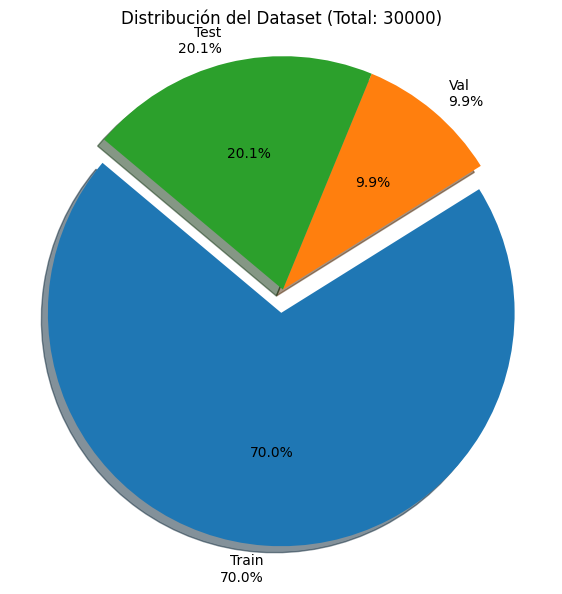

In [3]:
"""Distribución de muestras entre train, val y test (texto + pie chart)."""

n_train = x_train.shape[0]
n_val = x_val.shape[0]
n_test = x_test.shape[0]

total_muestras = n_train + n_val + n_test

p_train = (n_train / total_muestras) * 100
p_val = (n_val / total_muestras) * 100
p_test = (n_test / total_muestras) * 100

print("--- Desglose de Distribución de Datos ---")
print(f"Total de muestras calculadas: {total_muestras}")
print(f"Entrenamiento (Train): {n_train} muestras ({p_train:.2f}%)")
print(f"Validación (Val):      {n_val} muestras   ({p_val:.2f}%)")
print(f"Prueba (Test):         {n_test} muestras   ({p_test:.2f}%)")

etiquetas = [f'Train\n{p_train:.1f}%', f'Val\n{p_val:.1f}%', f'Test\n{p_test:.1f}%']
cantidades = [n_train, n_val, n_test]
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']
explode = (0.1, 0, 0)

plt.figure(figsize=(7, 7))
plt.pie(cantidades, explode=explode, labels=etiquetas, colors=colores,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title(f'Distribución del Dataset (Total: {total_muestras})')
plt.axis('equal')
plt.show()

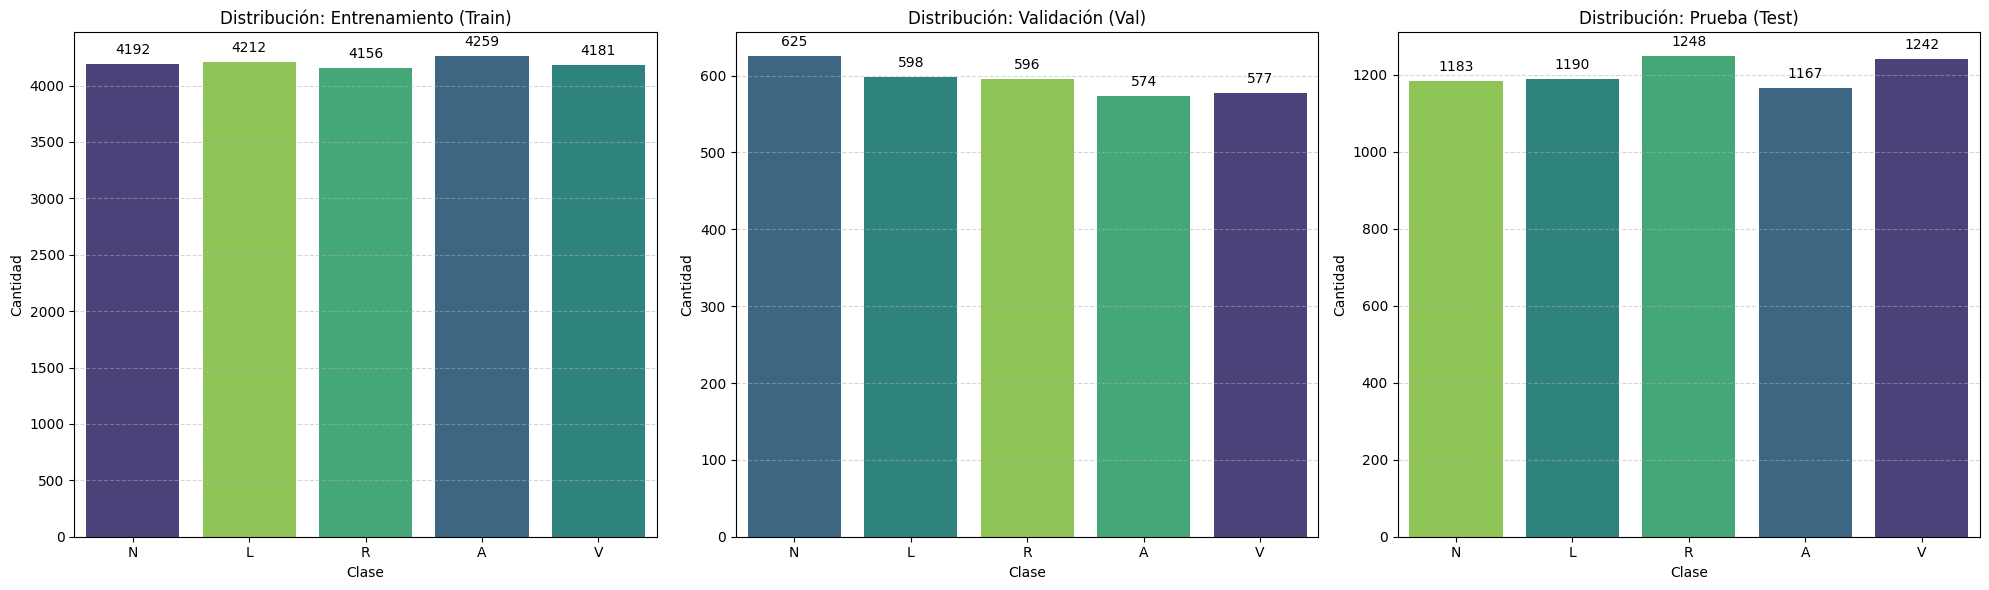

In [4]:
"""Distribución de clases en train, val y test (barras por clase)."""

datasets = [
    ("Entrenamiento (Train)", y_train),
    ("Validación (Val)", y_val),
    ("Prueba (Test)", y_test),
]

classes_order = CLASS_LABELS
mapa_clases = {idx: label for idx, label in enumerate(CLASS_LABELS)}

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for i, (titulo, y_data) in enumerate(datasets):
    ax = axes[i]

    if y_data.ndim > 1:
        y_ints = np.argmax(y_data, axis=1)
    else:
        y_ints = y_data

    df_temp = pd.DataFrame(y_ints, columns=['Clase'])
    df_temp['Nombre_Clase'] = df_temp['Clase'].map(mapa_clases)

    sns.countplot(
        x='Nombre_Clase',
        hue='Nombre_Clase',
        legend=False,
        data=df_temp,
        order=classes_order,
        palette='viridis',
        ax=ax,
    )

    ax.set_title(f'Distribución: {titulo}')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    for p in ax.patches:
        height = int(p.get_height()) if not np.isnan(p.get_height()) else 0
        ax.annotate(
            f'{height}',
            (p.get_x() + p.get_width() / 2.0, height),
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
            xytext=(0, 5),
            textcoords='offset points',
        )

plt.tight_layout()
plt.show()

## ⚙️ Visualización de las señales temporales del Dataset ECG

Etiqueta en onehot encoding: [0. 0. 1. 0. 0.]
La etiqueta de la muestra es R


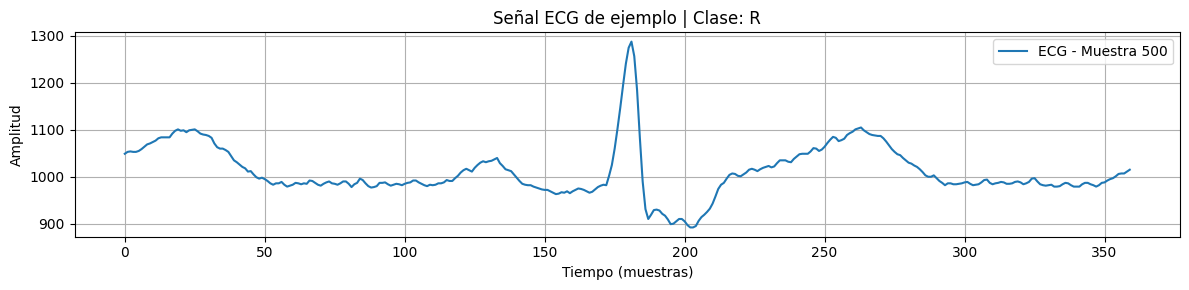

In [5]:
"""Ejemplo de una señal ECG de test y su etiqueta real."""

sample_i = 500

test_one_hot = y_test[sample_i]
idx = np.argmax(test_one_hot)
label = CLASS_LABELS[idx]

print(f"Etiqueta en onehot encoding: {test_one_hot}")
print(f"La etiqueta de la muestra es {label}")

plt.figure(figsize=(12, 3))
plt.plot(x_test[sample_i], label=f"ECG - Muestra {sample_i}")
plt.title(f"Señal ECG de ejemplo | Clase: {label}")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

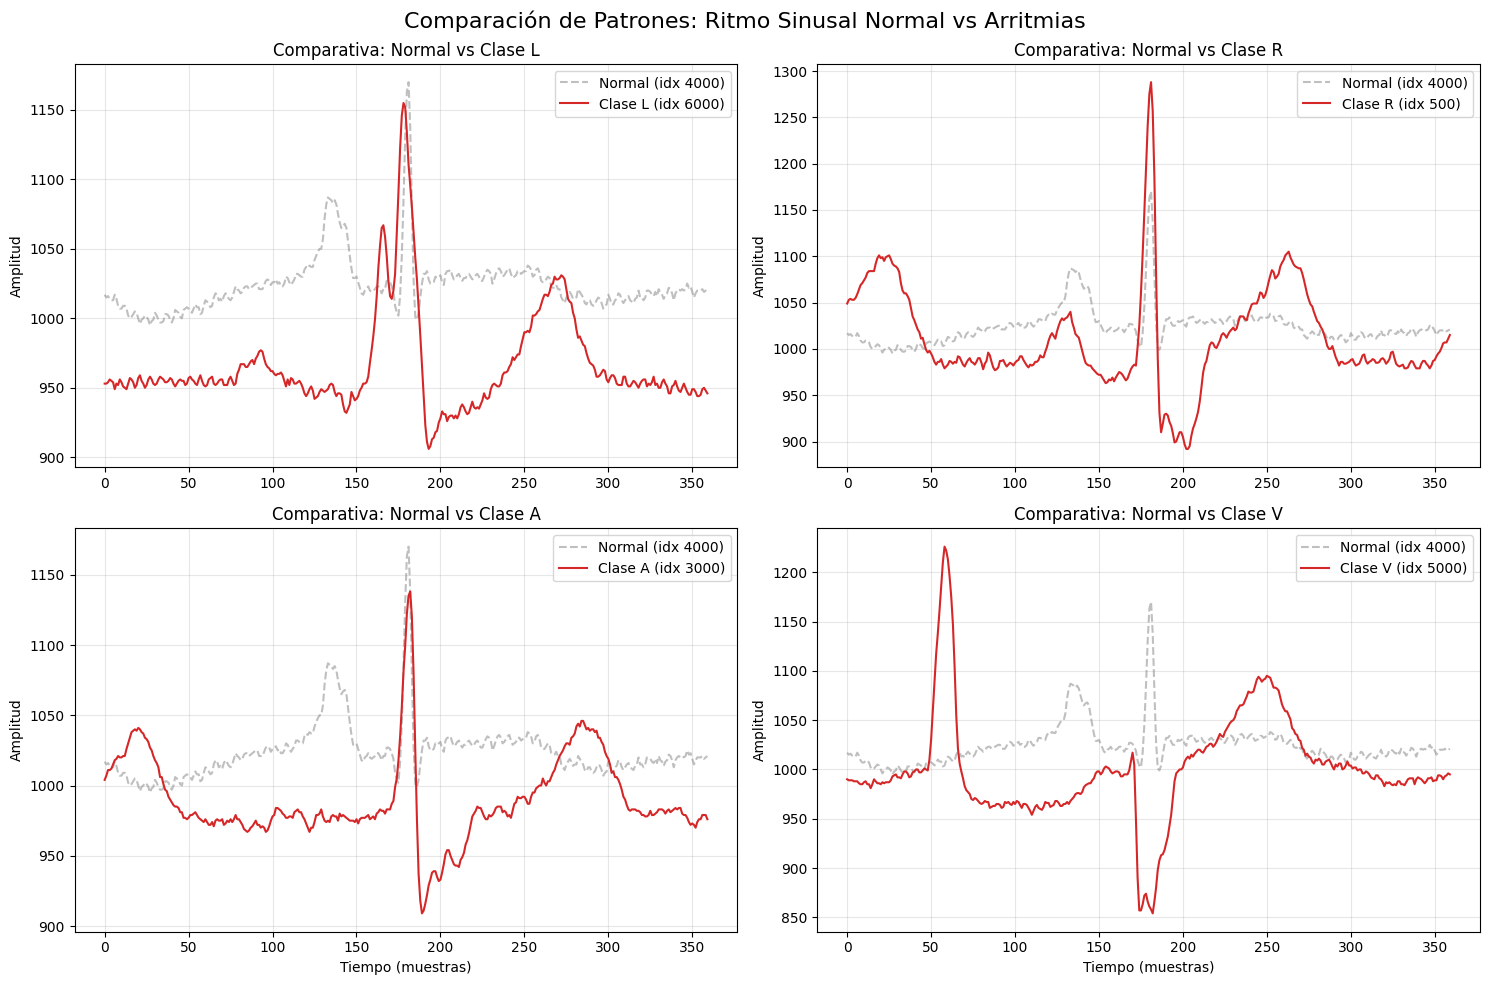

In [6]:
"""Comparación entre un latido normal y ejemplos de cada arritmia."""

indices_demo = {
    'N': 4000,
    'L': 6000,
    'R': 500,
    'A': 3000,
    'V': 5000,
}

idx_normal = indices_demo['N']
senal_normal = x_test[idx_normal]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

arritmias_a_comparar = ['L', 'R', 'A', 'V']

for i, tipo_arritmia in enumerate(arritmias_a_comparar):
    idx_arr = indices_demo[tipo_arritmia]
    senal_arr = x_test[idx_arr]

    ax = axes[i]
    ax.plot(senal_normal, color='gray', alpha=0.5, linestyle='--', label=f'Normal (idx {idx_normal})')
    ax.plot(senal_arr, color='tab:red', linewidth=1.5, label=f'Clase {tipo_arritmia} (idx {idx_arr})')

    ax.set_title(f'Comparativa: Normal vs Clase {tipo_arritmia}')
    ax.set_ylabel('Amplitud')
    if i >= 2:
        ax.set_xlabel('Tiempo (muestras)')

    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle("Comparación de Patrones: Ritmo Sinusal Normal vs Arritmias", fontsize=16)
plt.tight_layout()
plt.show()

## $$\textbf{Construcción del modelo CNN}$$
<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/vicente-alvarado/ECG-Arrhythmia-Classification-CNN1D/main/assets/ArquitectureCNN1D.png" width="1000" height="200">
  <p style="font-size: 14px;">Figura 1. Arquitectura general de la red neuronal convolucional 1D (CNN1D) basado en el paper.</p>
</div>

---

## ⚙️ Arquitectura CNN1D

In [7]:
"""Arquitectura CNN1D para clasificación de latidos ECG."""

def build_cnn_ecg_model(input_length: int = INPUT_LENGTH,
                        n_channels: int = N_CHANNELS,
                        n_classes: int = N_CLASSES) -> keras.Model:
    """Devuelve un modelo CNN1D para ECG."""
    model = Sequential()

    model.add(
        Conv1D(
            filters=16,
            kernel_size=9,
            activation="relu",
            input_shape=(input_length, n_channels),
        )
    )
    model.add(MaxPool1D(pool_size=3))

    model.add(Conv1D(filters=24, kernel_size=11, activation="relu"))
    model.add(MaxPool1D(pool_size=3))

    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(n_classes, activation="softmax"))

    return model


model = build_cnn_ecg_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 352, 16)           160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 117, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 107, 24)           4248      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 35, 24)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 35, 24)            0         
                                                                 
 flatten (Flatten)           (None, 840)               0

# Cálculo de Dimensiones y Parámetros de la Red CNN1D

A continuación se detalla el cálculo paso a paso de la longitud de señal ($L_{in}, L_{out}$) y el número de parámetros entrenables por capa.

**Glosario:**
- $L_{in}$: Longitud de entrada.
- $L_{out}$: Longitud de salida.
- $p$: Padding (0 para 'valid').
- $k$: Kernel Size (Tamaño de ventana).
- $s$: Stride (Paso).
- $C_{in}$: Canales de entrada.
- $F$: Filtros (Canales de salida).

---

### 1. Primera Capa Conv1D

**A. Cálculo de Dimensiones**

Tamaño de entrada:
$$(batch\_size, L_{in}, C_{in})$$
$$(None, 360, 1)$$

- $L_{in} = 360$
- $k = 9, s = 1, p = 0$

$$
L_{out} = \left\lfloor \frac{360 + 2(0) - 9}{1} \right\rfloor + 1
$$

- $L_{out} = 352$

Tamaño de salida:
$$(None, 352, 16)$$

**B. Cálculo de Parámetros**
$$Param = (k \times C_{in} \times F) + F$$

- $k=9, C_{in}=1, F=16$

$$
Param = (9 \times 1 \times 16) + 16 = \mathbf{160}
$$

---

### 2. Primera Capa MaxPool1D

**A. Cálculo de Dimensiones**

Tamaño de entrada:
$$(None, 352, 16)$$

- $L_{in} = 352$
- $k = 3$ (pool size), $s = 3$ (default)

$$
L_{out} = \left\lfloor \frac{352}{3} \right\rfloor
$$

- $L_{out} = 117$

Tamaño de salida:
$$(None, 117, 16)$$

**B. Cálculo de Parámetros**
- Las capas de Pooling no tienen parámetros entrenables.
- $Param = \mathbf{0}$

---

### 3. Segunda Capa Conv1D

**A. Cálculo de Dimensiones**

Tamaño de entrada:
$$(None, 117, 16)$$

- $L_{in} = 117$
- $k = 11, s = 1, p = 0$

$$
L_{out} = \left\lfloor \frac{117 + 2(0) - 11}{1} \right\rfloor + 1
$$

- $L_{out} = 107$

Tamaño de salida:
$$(None, 107, 24)$$

**B. Cálculo de Parámetros**
$$Param = (k \times C_{in} \times F) + F$$

- $k=11, C_{in}=16, F=24$

$$
Param = (11 \times 16 \times 24) + 24 = \mathbf{4,248}
$$

---

### 4. Segunda Capa MaxPool1D

**A. Cálculo de Dimensiones**

Tamaño de entrada:
$$(None, 107, 24)$$

- $L_{in} = 107$
- $k = 3, s = 3$

$$
L_{out} = \left\lfloor \frac{107}{3} \right\rfloor
$$

- $L_{out} = 35$

Tamaño de salida:
$$(None, 35, 24)$$

**B. Cálculo de Parámetros**
- $Param = \mathbf{0}$

---

### 5. Capas Densas (Clasificación)

Tras el **Flatten**, la entrada se convierte en un vector de tamaño:
$$35 \times 24 = 840 \text{ neuronas de entrada}$$

**Capa Dense 1 (128 unidades):**
$$Param = (N_{in} \times N_{out}) + Bias$$
$$Param = (840 \times 128) + 128 = \mathbf{107,648}$$

**Capa Dense 2 (64 unidades):**
$$Param = (128 \times 64) + 64 = \mathbf{8,256}$$

**Capa Salida (5 unidades):**
$$Param = (64 \times 5) + 5 = \mathbf{325}$$

---

### Resumen Total
$$Total Params = 160 + 4,248 + 107,648 + 8,256 + 325 = \mathbf{120,637}$$

## ⚙️ Entrenamiento del modelo

In [8]:
"""Compila y entrena el modelo CNN1D."""

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=1,
)

Epoch 1/10
657/657 [==============================] - 25s 14ms/step - loss: 10.2458 - accuracy: 0.2130 - val_loss: 0.5368 - val_accuracy: 0.3000
Epoch 2/10
657/657 [==============================] - 8s 13ms/step - loss: 0.6466 - accuracy: 0.2879 - val_loss: 0.4916 - val_accuracy: 0.5774
Epoch 3/10
657/657 [==============================] - 9s 13ms/step - loss: 0.4943 - accuracy: 0.3969 - val_loss: 0.4311 - val_accuracy: 0.6175
Epoch 4/10
657/657 [==============================] - 7s 11ms/step - loss: 0.4298 - accuracy: 0.4854 - val_loss: 0.3787 - val_accuracy: 0.6690
Epoch 5/10
657/657 [==============================] - 9s 13ms/step - loss: 0.3866 - accuracy: 0.5627 - val_loss: 0.3246 - val_accuracy: 0.7003
Epoch 6/10
657/657 [==============================] - 8s 11ms/step - loss: 0.3539 - accuracy: 0.6205 - val_loss: 0.2876 - val_accuracy: 0.7545
Epoch 7/10
657/657 [==============================] - 9s 13ms/step - loss: 0.3212 - accuracy: 0.6737 - val_loss: 0.2528 - val_accuracy: 0.81

## 📈 Visualización del desempeño

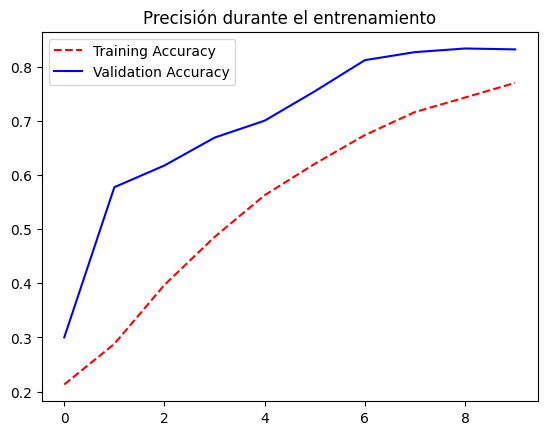

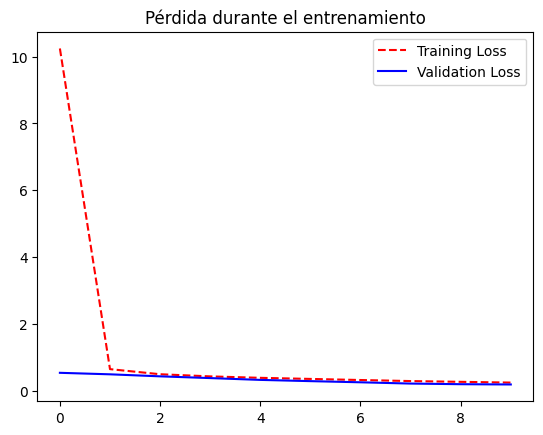

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, 'r--', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

plt.plot(loss, 'r--', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

In [10]:
import os

# 1. Definir el nombre de la carpeta
model_dir = 'model'

# 2. Crear la carpeta si no existe
# exist_ok=True evita errores si ya corriste el código antes
os.makedirs(model_dir, exist_ok=True)

print(f"Carpeta '{model_dir}' verificada/creada exitosamente.")

Carpeta 'model' verificada/creada exitosamente.


## 💾 Guardar modelo

In [11]:
model.save("model/CNN_ECG_model.h5")

## ⚙️ Predicción

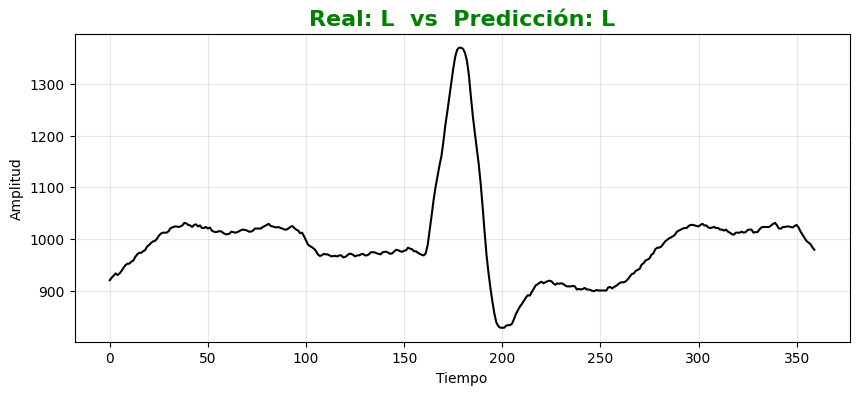

In [12]:
"""Predicción y visualización de una señal ECG de test."""

i = 24

senal = x_test[i]
prediccion = model.predict(senal.reshape(1, INPUT_LENGTH, N_CHANNELS), verbose=0)

idx_pred = np.argmax(prediccion)
idx_real = np.argmax(y_test[i]) if y_test.ndim > 1 else int(y_test[i])

color_estado = "green" if idx_pred == idx_real else "red"

plt.figure(figsize=(10, 4))
plt.plot(senal, color="black", label="Señal ECG")

plt.title(
    f"Real: {CLASS_LABELS[idx_real]}  vs  Predicción: {CLASS_LABELS[idx_pred]}",
    color=color_estado,
    fontsize=16,
    fontweight="bold",
)

plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
"""Cálculo de predicciones en el conjunto de test (clases reales, probabilidades y clases predichas)."""

# Clases reales a partir de y_test (one-hot -> entero si aplica)
y_true_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test.astype(int)

# Probabilidades predichas para todo el conjunto de test
y_pred_probs = model.predict(
    x_test.reshape(-1, INPUT_LENGTH, N_CHANNELS),
    verbose=0,
)

# Clases predichas a partir de las probabilidades
y_pred_classes = np.argmax(y_pred_probs, axis=1)


NameError: name 'y_true_classes' is not defined

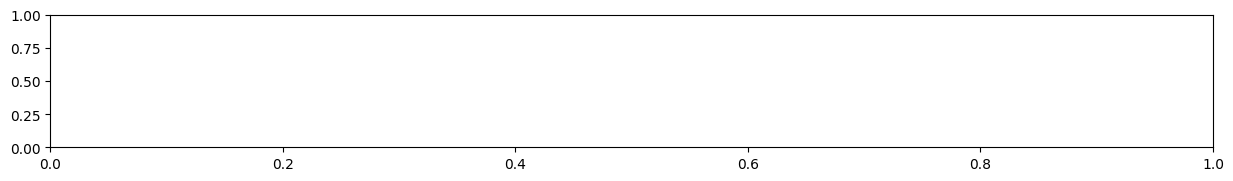

In [13]:
"""Varias señales de test con clase real y predicción."""

num_muestras = 5
indices_aleatorios = np.random.choice(len(x_test), num_muestras, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices_aleatorios):
    plt.subplot(num_muestras, 1, i + 1)

    senal = x_test[idx]
    clase_real = CLASS_LABELS[int(y_true_classes[idx])]
    clase_pred = CLASS_LABELS[int(y_pred_classes[idx])]
    probabilidad = np.max(y_pred_probs[idx]) * 100

    color_titulo = "green" if clase_real == clase_pred else "red"

    plt.plot(senal, color="black", linewidth=1)
    plt.title(
        f"Muestra {idx} | Real: {clase_real} | Predicho: {clase_pred} ({probabilidad:.2f}%)",
        color=color_titulo,
        fontweight="bold",
    )
    plt.ylabel("Amplitud")
    plt.grid(True, alpha=0.3)

    if i < num_muestras - 1:
        plt.xticks([])
    else:
        plt.xlabel("Tiempo (muestras)")

plt.tight_layout()
plt.show()

In [14]:
"""Reporte de clasificación y matriz de confusión en test."""

print("--- Reporte de Clasificación ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_LABELS))

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
)

plt.title("Matriz de Confusión (Test Set)")
plt.ylabel("Etiqueta Real (True Label)")
plt.xlabel("Predicción del Modelo (Predicted Label)")
plt.show()

--- Reporte de Clasificación ---


NameError: name 'y_true_classes' is not defined